In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sensorSelection import get_sensor_selections
from makeModel import df_to_X_y, buildModel, trainModel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load filtered data, compute optimized sensor selection as well as 3 lazy sensor selections

In [ ]:
dist = 5
k = 50
types = ['random', 'geographic', 'variance', 'optimized'] #geographic isn't super efficient to compute so we can take it out until we need it
df_mag_sqrt, lat_dict, lon_dict, sensor_selections = get_sensor_selections(dist=dist,k=k,types=types)

Looking for file at data/filtered_historicalForecasts/5km_historicalForecast2024.csv... FOUND!

Selection cache file found at data/selection_cache.csv
Loaded random selection from cache.
Loaded geographic selection from cache.
Loaded variance selection from cache.
Loaded optimized selection from cache.


# Plot Samples

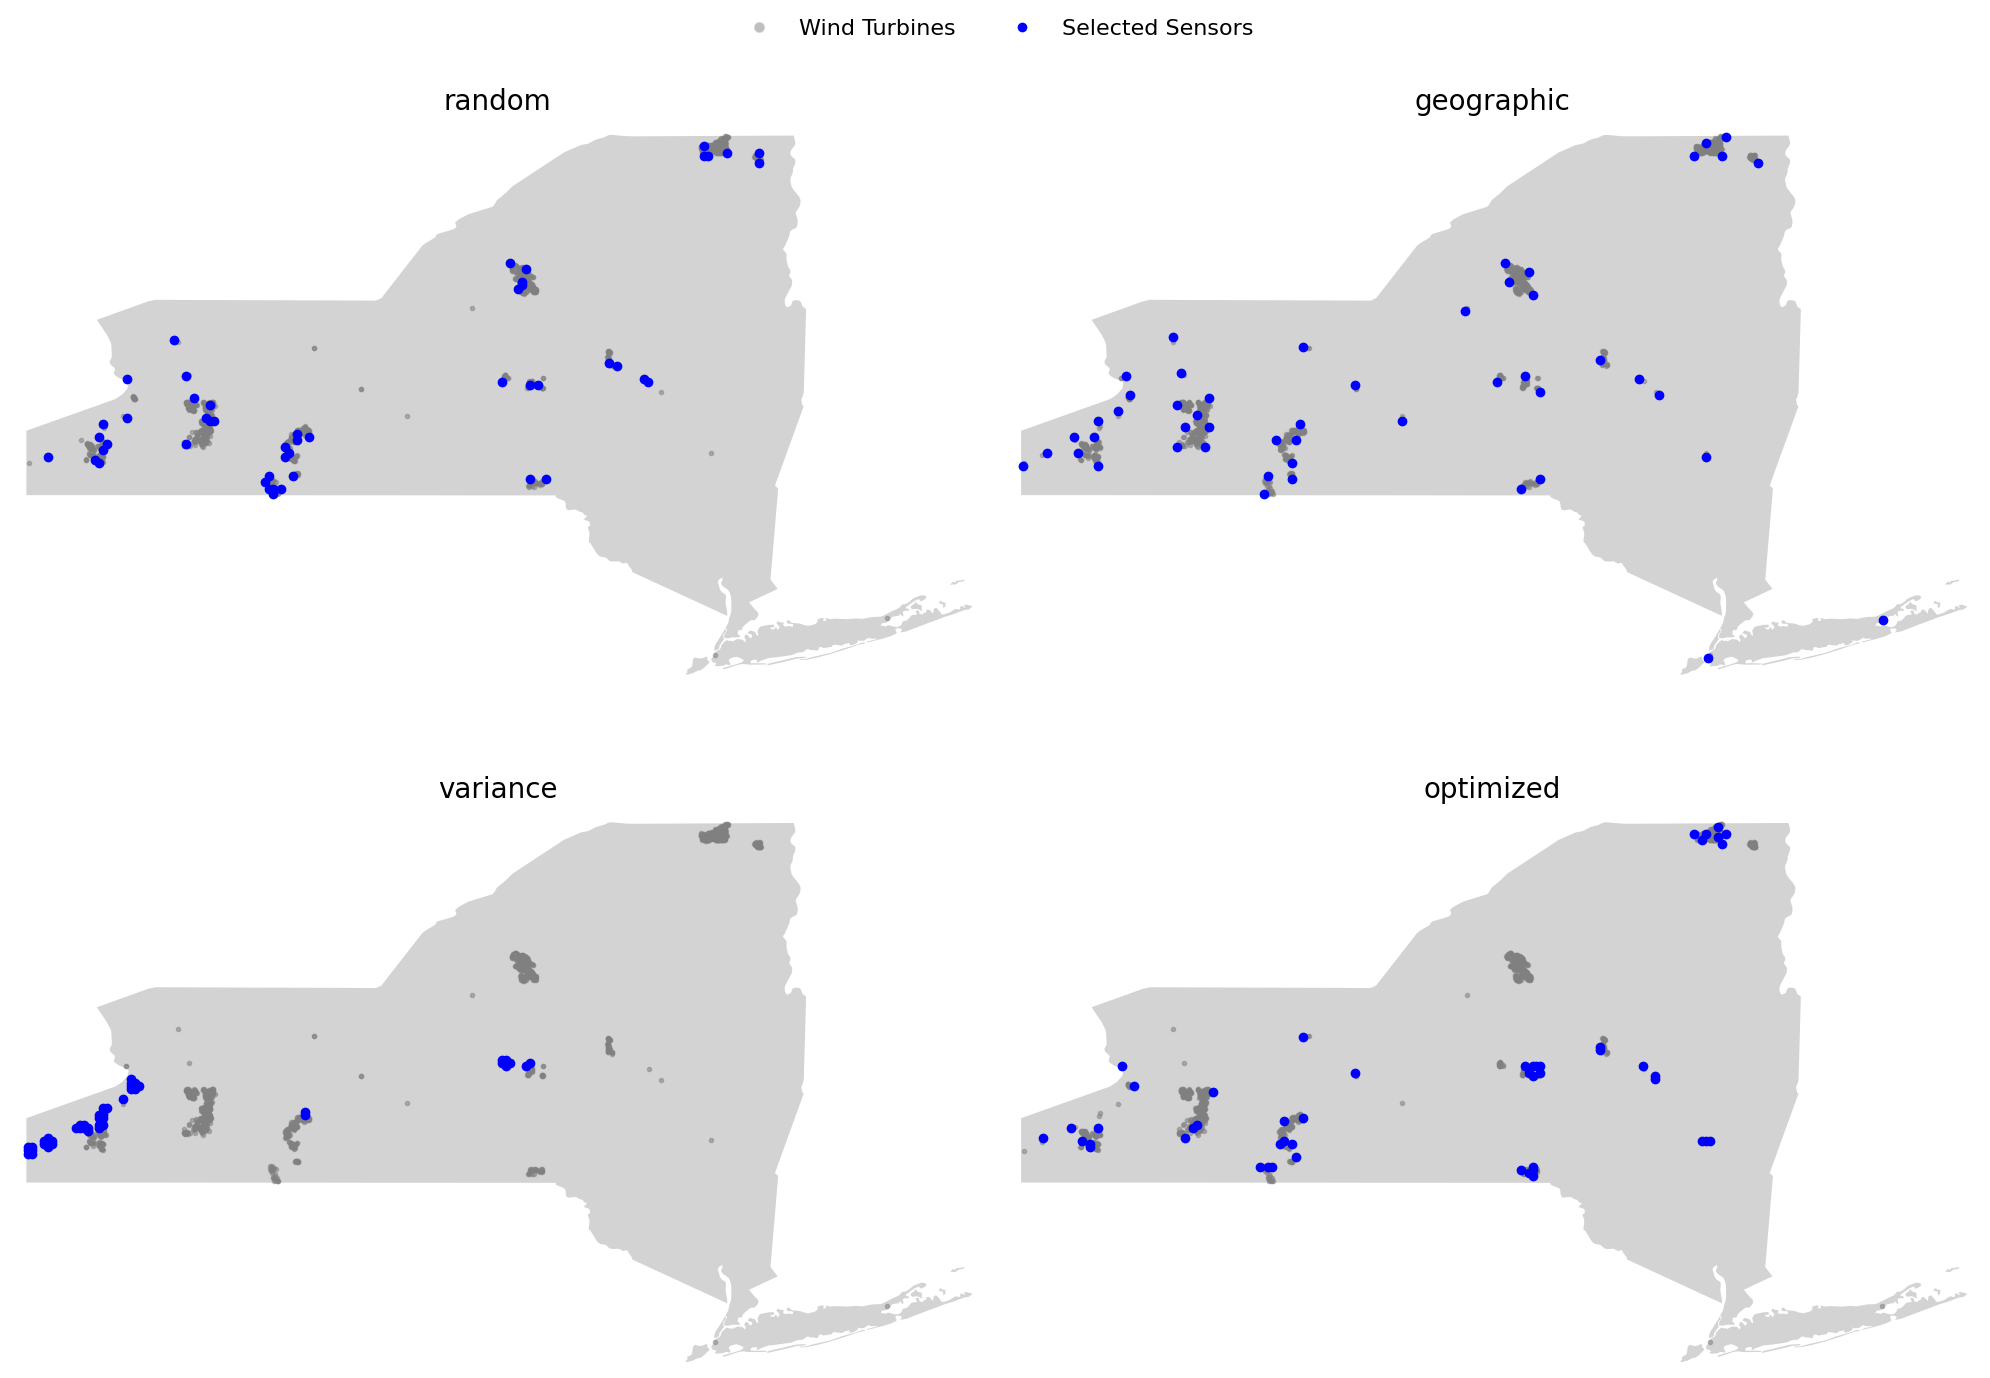

In [29]:
from plotting.plotSelections import plot_samples
coords_dict = {}
for type in types:
    coords_dict[type] = []
    for index in sensor_selections[type]:
        coords_dict[type].append((lat_dict[index], lon_dict[index]))

plot_samples(coords_dict)

# Prediction

In [12]:
energy = pd.read_csv('data/historical_energy.csv')

def dateparser(date_str):
    # Adjust the timezone offset format to ISO 8601 (from -05 to -05:00)
    date_str = str(date_str).strip()
    date_str = date_str + ":00"  # Insert the colon in the timezone offset
    date = pd.to_datetime(date_str, format="%Y-%m-%dT%H%z").tz_convert("America/New_York")
    return date

energy['period'] =  energy["period"].astype(str).str.strip().apply(dateparser)

start_ny = pd.Timestamp('2024-01-01', tz='America/New_York')
end_ny = pd.Timestamp('2024-12-31', tz='America/New_York')
energy = energy[(energy['period'] >= start_ny) & (energy['period'] < end_ny)]
energy = energy.set_index('period')

Epoch 1/100
209/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8752 - root_mean_squared_error: 0.9355
Epoch 1: val_loss improved from inf to 1.62926, saving model to models/lstm_optimized.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8751 - root_mean_squared_error: 0.9354 - val_loss: 1.6293 - val_root_mean_squared_error: 1.2764
Epoch 2/100
204/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8741 - root_mean_squared_error: 0.9348
Epoch 2: val_loss improved from 1.62926 to 1.60314, saving model to models/lstm_optimized.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8740 - root_mean_squared_error: 0.9347 - val_loss: 1.6031 - val_root_mean_squared_error: 1.2662
Epoch 3/100
208/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8732 - root_mean_squared_error: 0.9344
Epoch 3: val_loss did not improve from 1.60314
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8730 - root_mean_squared_error: 0.9343 - val_loss: 1.6127 - val_root_mean_squared_error: 1.2699
Epoch 4/100
211/21

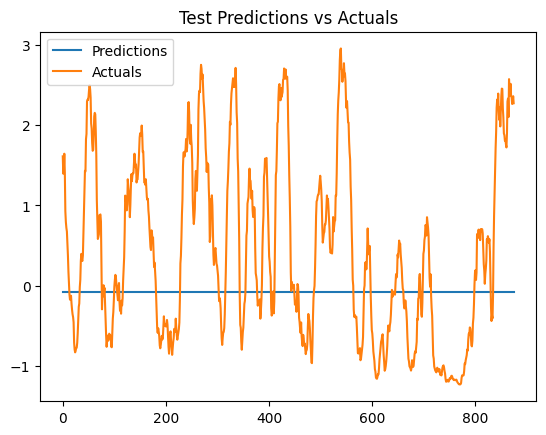

In [13]:
optimal_selection = sensor_selections['optimized']
# Preprocessing data
# Reset the index of energy (which becomes RangeIndex)
energy = energy.reset_index(drop=True)

# Remove timezone from df_mag_sqrt index
df_mag_sqrt.index = df_mag_sqrt.index.tz_localize(None)

# Concatenate the dataframes, now with unique and aligned indices
df_combined = pd.concat([df_mag_sqrt[optimal_selection], energy['Megawatthours']], axis=1)

# Forward fill missing values
df_combined = df_combined.ffill()

# Drop any remaining NaNs just in case (e.g., at the very beginning)
df_combined = df_combined.dropna()

# Split back into features and target
X_df = df_combined[optimal_selection]
y_df = df_combined['Megawatthours']

# Normalize/Scale the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

# Scale the target variable
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_df.values.reshape(-1, 1))

# Create LSTM-ready sequences
X, y = df_to_X_y(X_scaled, y_scaled, window_size=24)

# Build the model
model = buildModel(X)

# Show model architecture
#model.summary()

# Train the model and evaluate on the test set
results, mse_score = trainModel(
    model,
    model_name="models/lstm_optimized.keras",
    X=X,
    y=y
)